In [50]:
# Standard Libraries
import copy
import itertools
import os
import time
from tempfile import TemporaryDirectory

# 3rd Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timm
import torch
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from tqdm import tqdm

In [51]:
# FOR USE ON GOOGLE COLAB

# from google.colab import drive
# drive.mount('/content/drive') # Mounts it to YOUR drive. Nishanth and Chad, you will have to add a shortcut to dataset-resized.
# # Dataset-realized is in the folder that was shared.
# import os

# # Path to the dataset folder
# folder_path = '/content/drive/My Drive/dataset-resized' # All images are 512 x 384
# #folder_path = '/content/drive/My Drive/24-782: ML and AI for Engineers - Project/4- Code/dataset-resized'  #Chad path

# #folder path for Nishanth
# folder_path = '/content/drive/My Drive/Courses/24-782: ML and AI for Engineers - Project/Code/dataset-resized'

folder_path = '../../data/dataset-resized' # My local path

This is used to prepare the data for labeling.

In [52]:
def prepare_data(data_dir):
    """
    Prepares the dataset for training/testing by organizing image paths and labels.

    Parameters:
    - data_dir (str): Directory containing the dataset, organized into subdirectories
      for each category.

    Returns:
    - tuple: Two lists containing the image file paths and corresponding labels.
    """

    # Define the categories of the dataset
    categories = ['Trash', 'Plastic', 'Paper', 'Metal', 'Glass', 'Cardboard']

    # Lists to hold the paths of the images and their labels
    image_paths = []
    labels = []  # Numerical labels: 0 for Trash, 1 for Plastic, etc.

    # Enumerate over categories to label the images accordingly
    for label, category in enumerate(categories):
            try:
                # Construct the directory path for the current category
                category_dir = os.path.join(data_dir, category)

                # Iterate through each file in the category directory
                for file in os.listdir(category_dir):
                    # Check if the file is an image
                    if file.endswith('.jpg') or file.endswith('.png'):
                        image_paths.append(os.path.join(category_dir, file))
                        labels.append(label)  # Assign the label to this image
            except Exception as e:
                print(f"Failed to process category {category} due to error: {e}")
                continue
    return image_paths, labels

In [53]:
image_paths, labels = prepare_data(folder_path)

In [54]:
class CustomDataset(Dataset):
    """
    A custom dataset class that extends PyTorch's Dataset class for image loading and preprocessing.

    Attributes:
    - image_paths (list): List of paths to the images.
    - labels (list): List of labels corresponding to the images.
    - transform (callable, optional): Optional transform to be applied on a sample.
    """

    def __init__(self, image_paths, labels, transform=None):
        """
        Initializes the dataset with images and labels.

        Parameters:
        - image_paths (list): List of paths to the images.
        - labels (list): List of labels for the images.
        - transform (callable, optional): Optional transform to apply on images.
        """

        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """

        return len(self.image_paths)

    def __getitem__(self, index):
        """
        Retrieves an image and its label from the dataset at the specified index.

        Parameters:
        - index (int): Index of the image and label to return.

        Returns:
        - tuple: A tuple containing the image and its label.
        """

        image_path = self.image_paths[index]
    
        # Print the image path for debugging
        # print(f"Accessing image: {image_path}")

        # Check if the file exists
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"The file {image_path} does not exist.")

        # Attempt to open the image file
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            # If an error occurs, print the error and the problematic file path
            print(f"Error opening image at {image_path}: {e}")
            raise

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[index], dtype=torch.long)
        return image, label

In [55]:
# Function for displaying an image, currently not used in the main workflow
def imshow(inp, title=None):
    """
    Displays an image with an optional title.

    Parameters:
    - inp (Tensor): The image tensor to display.
    - title (str, optional): Optional title to display above the image.
    """

    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to update the plot

In [56]:
# Split the data into training and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.15, random_state=0)

# Split the data into training, validation, and test sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.175, random_state=0)  # 0.175 x 0.85 ~= 0.15

# So, the data is split into 70% training, 15% validation, and 15% testing

In [57]:
# Normalization parameters found to be optimal for CIFAR dataset; may need adjustment for other datasets
normalization = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# Define the training data transformations
training_transform = transforms.Compose([
    transforms.Resize(256, antialias=True),  # Resize images to 256x256, with antialiasing
    transforms.RandomCrop(224),  # Crop randomly to 224x224 for data augmentation
    transforms.RandomRotation(20),  # Rotate images up to 20 degrees for data augmentation
    transforms.RandomHorizontalFlip(0.1),  # Horizontally flip images with a probability of 0.1 for data augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Randomly adjust color settings
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),  # Randomly adjust sharpness for data augmentation
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(*normalization),  # Normalize images using the specified mean and std dev
])

# Define the validation and test data transformations (simpler than training transformations)
transform = transforms.Compose([
    transforms.Resize(256, antialias=True),  # Resize images to 256x256, with antialiasing
    transforms.CenterCrop(224),  # Center crop images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(*normalization),  # Normalize images using the specified mean and std dev
])

In [58]:
def initialize_model(output_classes=6):
    """
    Initializes the ResNet-50 model pre-trained on ImageNet (just convolutional layers) and implements the final fully connected layer.

    Parameters:
    - output_classes (int): The number of classes for the final output layer.

    Returns:
    - model (torch.nn.Module): The modified model based on the pre-trained Resnet-50 feature representation.
    """

    # Load a pre-trained ResNet-50 model
    model = torchvision.models.resnet50(weights='IMAGENET1K_V1')

    # Freeze all the parameters in the model to prevent them from being updated during training
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of input features to the final fully connected layer
    in_features = model.fc.in_features # 2048 input features (from the last feature mapping layer of Resnet)

    # Replace the final fully connected layer with a new one that has the desired number of output classes
    model.fc = nn.Sequential(
        nn.Linear(in_features, 512),  # Reduce dimension from in_features to 512
        nn.ReLU(),                    # Apply ReLU activation function
        nn.Linear(512, 6)  # Final layer with 'output_classes' number of outputs
    )

    return model

def evaluate_model(model, dataloader, loss_fun, device):
    """
    Evaluates the model's performance on a given dataset.

    Parameters:
    - model: The neural network model to evaluate.
    - dataloader: The DataLoader containing the dataset for evaluation.
    - loss_fun: The loss function used to compute the model's loss.
    - device: The device (CPU or CUDA) on which the computations will be performed.

    Returns:
    - A tuple of average loss and accuracy over the dataset.
    """

    model.eval()  # Set the model to evaluation mode    test_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    with torch.no_grad():  # No gradients needed for evaluation
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)  # Move data to the same device as the model

            pred = model(x)
            _, predicted_classes = torch.max(pred, 1)
            correct_predictions = (predicted_classes == y).float()

            loss = loss_fun(pred, y.long())  # Ensure consistent data type
            val_loss += loss.item()
            val_acc += correct_predictions.sum().item() / y.size(0)

        val_loss /= len(dataloader)
        val_acc /= len(dataloader)

    return val_loss, val_acc


# Usage example
num_classes = 6  # Define the number of output classes you need
example_model = initialize_model(num_classes)
print(example_model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [59]:
# labels_mapping = {'Trash': 0, 'Plastic': 1, 'Paper': 2, 'Metal': 3, 'Glass': 4, 'Cardboard': 5}
# datasets_by_label = {}
# data_loaders_by_label = {}

# for label_name, label_id in labels_mapping.items():
#     # Filter indices for the current label
#     indices = [i for i, label in enumerate(labels) if label == label_id]

#     # Use the indices to create a Subset
#     subset = Subset(CustomDataset(image_paths, labels, transform=transform), indices)

#     # Store the subset using the label_name as key
#     datasets_by_label[label_name] = subset

#     # Create a DataLoader for the current label's dataset
#     data_loader = DataLoader(subset, batch_size=32, num_workers=1, shuffle=False)

#     # Store the DataLoader using the label_name as key
#     data_loaders_by_label[label_name] = data_loader

# for label_name, subset in datasets_by_label.items():
#     print(f"\nExamples from class: {label_name}")

#     # Get the first few indices from the subset.indices
#     example_indices = subset.indices[:5]  # Adjust the number of examples as needed

#     for idx in example_indices:
#         print(f"Path: {image_paths[idx]}, Label ID: {labels[idx]}")

In [60]:
def train(train_dataloader, val_dataloader, num_classes, N_epochs=10, lr=1e-5, step_size=15, gamma=0.9):
    """
    Trains and validates a model, saving the model with the best validation accuracy, and records the training and validation performance.

    Parameters:
    - train_dataloader (DataLoader): DataLoader for training data.
    - val_dataloader (DataLoader): DataLoader for validation data.
    - num_classes (int): Number of classes in the dataset.
    - N_epochs (int): Number of epochs to train for.
    - lr (float): Learning rate for the optimizer.
    - step_size (int): Step size for the learning rate scheduler.
    - gamma (float): Decay rate for the learning rate scheduler.

    Returns:
    - A dictionary containing the model with the best validation accuracy, training losses, training accuracies, validation losses, and validation accuracies.
    """

    # Set the device to GPU if available, else CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # If a CUDA-capable device is detected, print its name
    if device.type == 'cuda':
        gpu_name = torch.cuda.get_device_name(0)
        print(f"NVIDIA Graphics Card: {gpu_name}")

    # Initialize the model and move it to the appropriate device
    model = initialize_model(num_classes)
    model.to(device)

    # Define the loss function and the optimizer
    loss_fun = nn.CrossEntropyLoss()
    loss_fun.to(device)
    optimizer = optim.Adam(params=model.parameters(), lr=lr)

    # Define the learning rate scheduler
    lr_schedule = lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

    # Initialize lists to store the performance metrics
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    # Variable to keep track of the best validation accuracy
    best_acc = 0.0
    # Variable to store the model weights corresponding to the best validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())

    # Training loop
    for epoch in tqdm(range(N_epochs)):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        train_correct = 0
        total = 0

        # Iterate over the training data
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)  # Move data to the correct device
            pred = model(x)  # Forward pass: compute the model output
            loss = loss_fun(pred, y.long())  # Compute the loss
            optimizer.zero_grad()  # Zero the gradients to prevent accumulation
            loss.backward()  # Backward pass: compute the gradient of the loss with respect to model parameters
            optimizer.step()  # Update model parameters

            # Accumulate the training loss and correct predictions to calculate accuracy
            train_loss += loss.item()
            _, predicted = torch.max(pred, 1)
            train_correct += (predicted == y).sum().item()
            total += y.size(0)

        # Compute the average training loss and accuracy for the epoch
        train_loss /= len(train_dataloader)
        train_acc = train_correct / total
        training_losses.append(train_loss)
        training_accuracies.append(train_acc)

        # Validate the model
        val_loss, val_acc = evaluate_model(model, val_dataloader, loss_fun, device)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_acc)

        # Check if the current model is the best one based on validation loss
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Update the learning rate
        lr_schedule.step()

        # Print the performance metrics for the epoch
        print(f"Epoch {epoch+1}/{N_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Return the model and performance metrics
    return {
        "model": model,
        "training_losses": training_losses,
        "training_accuracies": training_accuracies,
        "validation_losses": validation_losses,
        "validation_accuracies": validation_accuracies
    }

In [61]:
# Create dataset objects for training, validation, and testing
train_dataset = CustomDataset(train_paths, train_labels, transform=training_transform)
val_dataset = CustomDataset(val_paths, val_labels, transform=transform)
test_dataset = CustomDataset(test_paths, test_labels, transform=transform)

# Define the hyperparameter grid
learning_rates = [1e-5, 1e-4]  # CV learning rates
batch_sizes = [32]  # CV batch sizes
num_epochs_list = [20]  # CV number of epochs
step_sizes = [5,10]  # CV step sizes

# Record the best performance and metrics
best_acc = 0
best_hyperparams = None
best_model_info = {}

# Record time for compute calculations later.
start_time = time.time()

# VERY IMPORTANT TO BE AWARE OF THE FLUCTUATIONS IN THE GPU UTILIZATION AND THE PEAK PERFORMANCE.
# IF THIS IS BEING RUN SOMEWHERE ELSE THIS MUST BE UPDATED.
# THESE VALUES ARE FOR THE NVIDIA GEFORCE RTX 3050 Ti ON NIKOLAJ'S LAPTOP. NOT UNIVERSAL AND ALSO THE AVERAGE UTALIZATION IS A GUESS FROM MY EXPERIENCE.
peak_performance_tflops = 9.76 # Hypothetical peak performance in TFLOP/s of NVIDIA GeForce RTX 3050 Ti
average_utilization = 0.20  # Assumed average (from my experience on task manager)

# Iterate over all combinations of hyperparameters
for lr, batch_size, num_epochs, step_size in itertools.product(learning_rates, batch_sizes, num_epochs_list, step_sizes):
    print(f"Training with lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}, step_size={step_size}")

    # Create data loaders for batching, shuffling, and iterating over the datasets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Train the model with the current set of hyperparameters
    results = train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_classes=6, N_epochs=num_epochs, lr=lr, step_size=step_size)
    model = results["model"]

    # Evaluate the model on the testing set
    loss_fun = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if device.type == 'cuda':
        gpu_name = torch.cuda.get_device_name(0)
        print(f"NVIDIA Graphics Card: {gpu_name}")

    test_loss, test_acc = evaluate_model(model, test_dataloader, loss_fun, device)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Save the model and metrics if it has the best accuracy so far on the testing set
    if test_acc > best_acc:
        best_acc = test_acc
        best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'num_epochs': num_epochs}
        best_model_info = {
            "state_dict": copy.deepcopy(model.state_dict()),
            "training_losses": results["training_losses"],
            "training_accuracies": results["training_accuracies"],
            "validation_losses": results["validation_losses"],
            "validation_accuracies": results["validation_accuracies"]
        }


end_time = time.time() # end time in seconds
total_time = end_time - start_time # total time in seconds
total_compute_units_tflops = peak_performance_tflops * average_utilization * total_time # total compute in TFLOP/s

# Convert TFLOPs to TFLOP-hours by dividing by the number of seconds in an hour
total_compute_units_tfloph = total_compute_units_tflops / 3600

print(f"Assuming peak performance of {peak_performance_tflops} TFLOP/s and average utilization of {average_utilization}:")
print(f"Total training time: {total_time} seconds")
print(f"Total compute units: {total_compute_units_tfloph} TFLOP-hours")

# Output the best performing set of hyperparameters based on the testing dataset
print(f"Best performing model on testing set: {best_hyperparams} with accuracy: {best_acc}")

# Save the best model and associated metrics
torch.save(best_model_info, 'RESNET50_best_model.pth')

Training with lr=1e-05, batch_size=32, num_epochs=20, step_size=5
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


  5%|▌         | 1/20 [00:23<07:19, 23.14s/it]

Epoch 1/20, Train Loss: 1.7058, Train Acc: 0.2868, Val Loss: 1.6300, Val Acc: 0.3750


 10%|█         | 2/20 [00:42<06:19, 21.07s/it]

Epoch 2/20, Train Loss: 1.5894, Train Acc: 0.3936, Val Loss: 1.5319, Val Acc: 0.5773


 15%|█▌        | 3/20 [01:03<05:57, 21.04s/it]

Epoch 3/20, Train Loss: 1.4986, Train Acc: 0.5759, Val Loss: 1.4415, Val Acc: 0.6858


 20%|██        | 4/20 [01:24<05:36, 21.04s/it]

Epoch 4/20, Train Loss: 1.4141, Train Acc: 0.6318, Val Loss: 1.3529, Val Acc: 0.7153


 25%|██▌       | 5/20 [01:46<05:18, 21.22s/it]

Epoch 5/20, Train Loss: 1.3383, Train Acc: 0.6674, Val Loss: 1.2729, Val Acc: 0.7170


 30%|███       | 6/20 [02:07<04:58, 21.29s/it]

Epoch 6/20, Train Loss: 1.2841, Train Acc: 0.6652, Val Loss: 1.2132, Val Acc: 0.7309


 35%|███▌      | 7/20 [02:29<04:37, 21.31s/it]

Epoch 7/20, Train Loss: 1.2262, Train Acc: 0.6945, Val Loss: 1.1621, Val Acc: 0.7188


 40%|████      | 8/20 [02:50<04:14, 21.20s/it]

Epoch 8/20, Train Loss: 1.1658, Train Acc: 0.7058, Val Loss: 1.1056, Val Acc: 0.7361


 45%|████▌     | 9/20 [03:12<03:56, 21.53s/it]

Epoch 9/20, Train Loss: 1.1271, Train Acc: 0.7211, Val Loss: 1.0809, Val Acc: 0.7222


 50%|█████     | 10/20 [03:34<03:38, 21.81s/it]

Epoch 10/20, Train Loss: 1.0925, Train Acc: 0.7081, Val Loss: 1.0419, Val Acc: 0.7326


 55%|█████▌    | 11/20 [03:57<03:19, 22.17s/it]

Epoch 11/20, Train Loss: 1.0635, Train Acc: 0.7149, Val Loss: 1.0036, Val Acc: 0.7344


 60%|██████    | 12/20 [04:20<02:57, 22.23s/it]

Epoch 12/20, Train Loss: 1.0263, Train Acc: 0.7216, Val Loss: 0.9821, Val Acc: 0.7318


 65%|██████▌   | 13/20 [04:44<02:39, 22.74s/it]

Epoch 13/20, Train Loss: 0.9993, Train Acc: 0.7312, Val Loss: 0.9600, Val Acc: 0.7335


 70%|███████   | 14/20 [05:05<02:13, 22.28s/it]

Epoch 14/20, Train Loss: 0.9738, Train Acc: 0.7194, Val Loss: 0.9226, Val Acc: 0.7491


 75%|███████▌  | 15/20 [05:25<01:47, 21.58s/it]

Epoch 15/20, Train Loss: 0.9560, Train Acc: 0.7329, Val Loss: 0.9123, Val Acc: 0.7474


 80%|████████  | 16/20 [05:45<01:24, 21.15s/it]

Epoch 16/20, Train Loss: 0.9390, Train Acc: 0.7324, Val Loss: 0.8872, Val Acc: 0.7474


 85%|████████▌ | 17/20 [06:05<01:02, 20.80s/it]

Epoch 17/20, Train Loss: 0.9126, Train Acc: 0.7391, Val Loss: 0.8604, Val Acc: 0.7509


 90%|█████████ | 18/20 [06:25<00:41, 20.58s/it]

Epoch 18/20, Train Loss: 0.8965, Train Acc: 0.7499, Val Loss: 0.8561, Val Acc: 0.7483


 95%|█████████▌| 19/20 [06:45<00:20, 20.43s/it]

Epoch 19/20, Train Loss: 0.8812, Train Acc: 0.7403, Val Loss: 0.8480, Val Acc: 0.7491


100%|██████████| 20/20 [07:06<00:00, 21.32s/it]

Epoch 20/20, Train Loss: 0.8784, Train Acc: 0.7544, Val Loss: 0.8243, Val Acc: 0.7552
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


Test Loss: 0.8312, Test Accuracy: 0.7820
Training with lr=1e-05, batch_size=32, num_epochs=20, step_size=10
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


  5%|▌         | 1/20 [00:22<07:01, 22.18s/it]

Epoch 1/20, Train Loss: 1.7350, Train Acc: 0.2518, Val Loss: 1.6812, Val Acc: 0.2752


 10%|█         | 2/20 [00:46<07:00, 23.34s/it]

Epoch 2/20, Train Loss: 1.6257, Train Acc: 0.3738, Val Loss: 1.5901, Val Acc: 0.4427


 15%|█▌        | 3/20 [01:08<06:25, 22.65s/it]

Epoch 3/20, Train Loss: 1.5441, Train Acc: 0.5172, Val Loss: 1.5027, Val Acc: 0.5434


 20%|██        | 4/20 [01:29<05:51, 21.96s/it]

Epoch 4/20, Train Loss: 1.4600, Train Acc: 0.6042, Val Loss: 1.4146, Val Acc: 0.6727


 25%|██▌       | 5/20 [01:49<05:22, 21.49s/it]

Epoch 5/20, Train Loss: 1.3825, Train Acc: 0.6556, Val Loss: 1.3393, Val Acc: 0.6875


 30%|███       | 6/20 [02:09<04:54, 21.07s/it]

Epoch 6/20, Train Loss: 1.3102, Train Acc: 0.6911, Val Loss: 1.2545, Val Acc: 0.7066


 35%|███▌      | 7/20 [02:30<04:30, 20.84s/it]

Epoch 7/20, Train Loss: 1.2431, Train Acc: 0.6663, Val Loss: 1.1940, Val Acc: 0.7396


 40%|████      | 8/20 [02:50<04:07, 20.59s/it]

Epoch 8/20, Train Loss: 1.1790, Train Acc: 0.7160, Val Loss: 1.1370, Val Acc: 0.7214


 45%|████▌     | 9/20 [03:10<03:44, 20.38s/it]

Epoch 9/20, Train Loss: 1.1394, Train Acc: 0.6962, Val Loss: 1.0899, Val Acc: 0.7266


 50%|█████     | 10/20 [03:30<03:22, 20.26s/it]

Epoch 10/20, Train Loss: 1.1009, Train Acc: 0.7058, Val Loss: 1.0423, Val Acc: 0.7188


 55%|█████▌    | 11/20 [03:50<03:01, 20.20s/it]

Epoch 11/20, Train Loss: 1.0653, Train Acc: 0.7143, Val Loss: 1.0244, Val Acc: 0.7292


 60%|██████    | 12/20 [04:10<02:41, 20.22s/it]

Epoch 12/20, Train Loss: 1.0190, Train Acc: 0.7171, Val Loss: 0.9799, Val Acc: 0.7266


 65%|██████▌   | 13/20 [04:31<02:21, 20.27s/it]

Epoch 13/20, Train Loss: 1.0067, Train Acc: 0.7194, Val Loss: 0.9639, Val Acc: 0.7274


 70%|███████   | 14/20 [04:50<02:00, 20.16s/it]

Epoch 14/20, Train Loss: 0.9773, Train Acc: 0.7278, Val Loss: 0.9184, Val Acc: 0.7396


 75%|███████▌  | 15/20 [05:11<01:40, 20.17s/it]

Epoch 15/20, Train Loss: 0.9424, Train Acc: 0.7414, Val Loss: 0.9244, Val Acc: 0.7300


 80%|████████  | 16/20 [05:31<01:20, 20.16s/it]

Epoch 16/20, Train Loss: 0.9160, Train Acc: 0.7431, Val Loss: 0.8966, Val Acc: 0.7422


 85%|████████▌ | 17/20 [05:51<01:00, 20.21s/it]

Epoch 17/20, Train Loss: 0.8928, Train Acc: 0.7380, Val Loss: 0.8689, Val Acc: 0.7465


 90%|█████████ | 18/20 [06:11<00:40, 20.19s/it]

Epoch 18/20, Train Loss: 0.9039, Train Acc: 0.7324, Val Loss: 0.8652, Val Acc: 0.7378


 95%|█████████▌| 19/20 [06:31<00:20, 20.10s/it]

Epoch 19/20, Train Loss: 0.8621, Train Acc: 0.7600, Val Loss: 0.8315, Val Acc: 0.7552


100%|██████████| 20/20 [06:51<00:00, 20.60s/it]

Epoch 20/20, Train Loss: 0.8555, Train Acc: 0.7414, Val Loss: 0.8201, Val Acc: 0.7500
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


Test Loss: 0.8314, Test Accuracy: 0.7909
Training with lr=0.0001, batch_size=32, num_epochs=20, step_size=5
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


  5%|▌         | 1/20 [00:20<06:24, 20.24s/it]

Epoch 1/20, Train Loss: 1.4366, Train Acc: 0.4833, Val Loss: 1.1543, Val Acc: 0.6554


 10%|█         | 2/20 [00:40<06:03, 20.17s/it]

Epoch 2/20, Train Loss: 1.0182, Train Acc: 0.6883, Val Loss: 0.8818, Val Acc: 0.7318


 15%|█▌        | 3/20 [01:00<05:43, 20.24s/it]

Epoch 3/20, Train Loss: 0.8531, Train Acc: 0.7188, Val Loss: 0.7137, Val Acc: 0.7708


 20%|██        | 4/20 [01:20<05:22, 20.18s/it]

Epoch 4/20, Train Loss: 0.7812, Train Acc: 0.7318, Val Loss: 0.7551, Val Acc: 0.7292


 25%|██▌       | 5/20 [01:41<05:03, 20.22s/it]

Epoch 5/20, Train Loss: 0.6895, Train Acc: 0.7798, Val Loss: 0.6571, Val Acc: 0.7752


 30%|███       | 6/20 [02:01<04:42, 20.20s/it]

Epoch 6/20, Train Loss: 0.6575, Train Acc: 0.7753, Val Loss: 0.6175, Val Acc: 0.7804


 35%|███▌      | 7/20 [02:21<04:21, 20.15s/it]

Epoch 7/20, Train Loss: 0.6374, Train Acc: 0.7815, Val Loss: 0.6148, Val Acc: 0.8012


 40%|████      | 8/20 [02:41<04:02, 20.17s/it]

Epoch 8/20, Train Loss: 0.6340, Train Acc: 0.7888, Val Loss: 0.5971, Val Acc: 0.7873


 45%|████▌     | 9/20 [03:01<03:41, 20.17s/it]

Epoch 9/20, Train Loss: 0.5893, Train Acc: 0.7956, Val Loss: 0.5585, Val Acc: 0.8134


 50%|█████     | 10/20 [03:21<03:21, 20.19s/it]

Epoch 10/20, Train Loss: 0.5825, Train Acc: 0.8029, Val Loss: 0.5448, Val Acc: 0.8099


 55%|█████▌    | 11/20 [03:42<03:01, 20.19s/it]

Epoch 11/20, Train Loss: 0.5509, Train Acc: 0.8137, Val Loss: 0.5333, Val Acc: 0.8220


 60%|██████    | 12/20 [04:02<02:41, 20.17s/it]

Epoch 12/20, Train Loss: 0.5468, Train Acc: 0.8086, Val Loss: 0.5460, Val Acc: 0.8125


 65%|██████▌   | 13/20 [04:22<02:21, 20.15s/it]

Epoch 13/20, Train Loss: 0.5214, Train Acc: 0.8227, Val Loss: 0.5766, Val Acc: 0.7908


 70%|███████   | 14/20 [04:42<02:00, 20.16s/it]

Epoch 14/20, Train Loss: 0.5252, Train Acc: 0.8306, Val Loss: 0.5487, Val Acc: 0.8003


 75%|███████▌  | 15/20 [05:02<01:40, 20.16s/it]

Epoch 15/20, Train Loss: 0.5421, Train Acc: 0.8075, Val Loss: 0.5209, Val Acc: 0.8168


 80%|████████  | 16/20 [05:22<01:20, 20.16s/it]

Epoch 16/20, Train Loss: 0.4951, Train Acc: 0.8289, Val Loss: 0.5723, Val Acc: 0.7960


 85%|████████▌ | 17/20 [05:43<01:00, 20.28s/it]

Epoch 17/20, Train Loss: 0.5175, Train Acc: 0.8131, Val Loss: 0.5278, Val Acc: 0.8160


 90%|█████████ | 18/20 [06:03<00:40, 20.36s/it]

Epoch 18/20, Train Loss: 0.4928, Train Acc: 0.8165, Val Loss: 0.5143, Val Acc: 0.8177


 95%|█████████▌| 19/20 [06:24<00:20, 20.39s/it]

Epoch 19/20, Train Loss: 0.4655, Train Acc: 0.8379, Val Loss: 0.5582, Val Acc: 0.8082


100%|██████████| 20/20 [06:44<00:00, 20.24s/it]

Epoch 20/20, Train Loss: 0.4660, Train Acc: 0.8442, Val Loss: 0.5239, Val Acc: 0.8290
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


Test Loss: 0.5266, Test Accuracy: 0.8237
Training with lr=0.0001, batch_size=32, num_epochs=20, step_size=10
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


  5%|▌         | 1/20 [00:20<06:24, 20.22s/it]

Epoch 1/20, Train Loss: 1.4152, Train Acc: 0.5370, Val Loss: 1.1100, Val Acc: 0.7031


 10%|█         | 2/20 [00:40<06:03, 20.17s/it]

Epoch 2/20, Train Loss: 1.0214, Train Acc: 0.6849, Val Loss: 0.9806, Val Acc: 0.6580


 15%|█▌        | 3/20 [01:00<05:46, 20.36s/it]

Epoch 3/20, Train Loss: 0.8525, Train Acc: 0.7307, Val Loss: 0.7637, Val Acc: 0.7700


 20%|██        | 4/20 [01:22<05:34, 20.93s/it]

Epoch 4/20, Train Loss: 0.7365, Train Acc: 0.7532, Val Loss: 0.6879, Val Acc: 0.7778


 25%|██▌       | 5/20 [01:44<05:19, 21.32s/it]

Epoch 5/20, Train Loss: 0.7058, Train Acc: 0.7645, Val Loss: 0.7077, Val Acc: 0.7491


 30%|███       | 6/20 [02:06<05:01, 21.55s/it]

Epoch 6/20, Train Loss: 0.6631, Train Acc: 0.7708, Val Loss: 0.6264, Val Acc: 0.7708


 35%|███▌      | 7/20 [02:28<04:42, 21.77s/it]

Epoch 7/20, Train Loss: 0.6293, Train Acc: 0.7905, Val Loss: 0.6643, Val Acc: 0.7674


 40%|████      | 8/20 [02:51<04:24, 22.02s/it]

Epoch 8/20, Train Loss: 0.6043, Train Acc: 0.7911, Val Loss: 0.5827, Val Acc: 0.7969


 45%|████▌     | 9/20 [03:26<04:48, 26.21s/it]

Epoch 9/20, Train Loss: 0.5833, Train Acc: 0.7877, Val Loss: 0.6568, Val Acc: 0.7995


 50%|█████     | 10/20 [03:50<04:14, 25.42s/it]

Epoch 10/20, Train Loss: 0.5704, Train Acc: 0.8035, Val Loss: 0.6423, Val Acc: 0.8021


 55%|█████▌    | 11/20 [04:15<03:47, 25.28s/it]

Epoch 11/20, Train Loss: 0.5587, Train Acc: 0.8075, Val Loss: 0.5593, Val Acc: 0.8325


 60%|██████    | 12/20 [04:35<03:09, 23.74s/it]

Epoch 12/20, Train Loss: 0.5341, Train Acc: 0.8007, Val Loss: 0.5502, Val Acc: 0.7943


 65%|██████▌   | 13/20 [04:56<02:39, 22.82s/it]

Epoch 13/20, Train Loss: 0.5327, Train Acc: 0.8091, Val Loss: 0.5669, Val Acc: 0.7986


 70%|███████   | 14/20 [05:17<02:13, 22.26s/it]

Epoch 14/20, Train Loss: 0.5114, Train Acc: 0.8187, Val Loss: 0.5892, Val Acc: 0.7891


 75%|███████▌  | 15/20 [05:38<01:49, 21.93s/it]

Epoch 15/20, Train Loss: 0.5264, Train Acc: 0.8046, Val Loss: 0.5438, Val Acc: 0.7925


 80%|████████  | 16/20 [05:59<01:26, 21.65s/it]

Epoch 16/20, Train Loss: 0.5064, Train Acc: 0.8142, Val Loss: 0.6582, Val Acc: 0.7795


 85%|████████▌ | 17/20 [06:20<01:04, 21.52s/it]

Epoch 17/20, Train Loss: 0.5148, Train Acc: 0.8278, Val Loss: 0.6196, Val Acc: 0.7969


 90%|█████████ | 18/20 [06:41<00:42, 21.33s/it]

Epoch 18/20, Train Loss: 0.4916, Train Acc: 0.8210, Val Loss: 0.5805, Val Acc: 0.8186


 95%|█████████▌| 19/20 [07:02<00:21, 21.28s/it]

Epoch 19/20, Train Loss: 0.4760, Train Acc: 0.8323, Val Loss: 0.5568, Val Acc: 0.8177


100%|██████████| 20/20 [07:23<00:00, 22.19s/it]

Epoch 20/20, Train Loss: 0.4760, Train Acc: 0.8323, Val Loss: 0.5775, Val Acc: 0.8116
Using device: cuda
NVIDIA Graphics Card: NVIDIA GeForce RTX 2080


Test Loss: 0.5621, Test Accuracy: 0.8374
Assuming peak performance of 9.76 TFLOP/s and average utilization of 0.2:
Total training time: 1700.7790820598602 seconds
Total compute units: 0.9222002133835686 TFLOP-hours
Best performing model on testing set: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 20} with accuracy: 0.8374255952380952


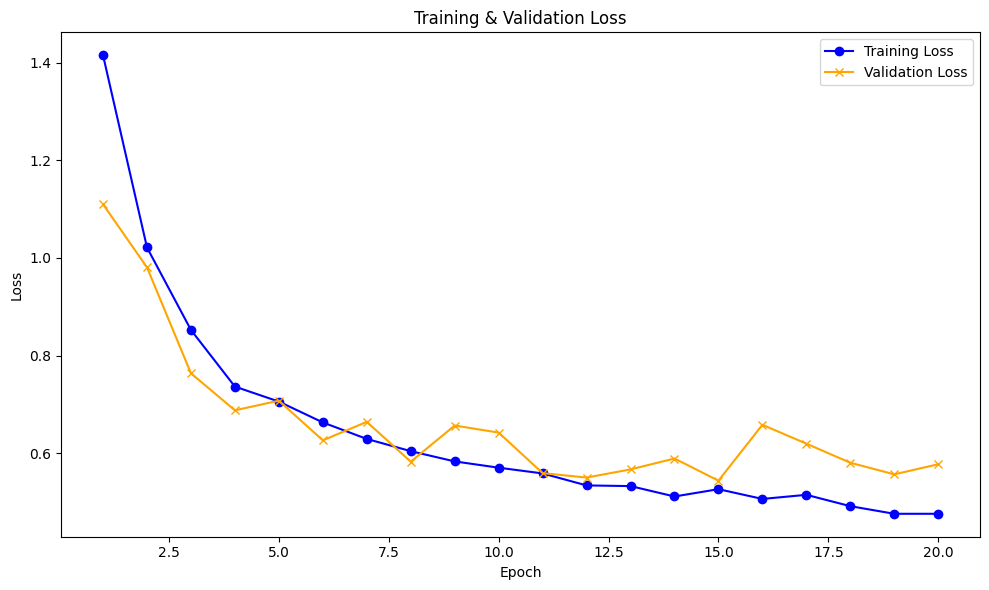

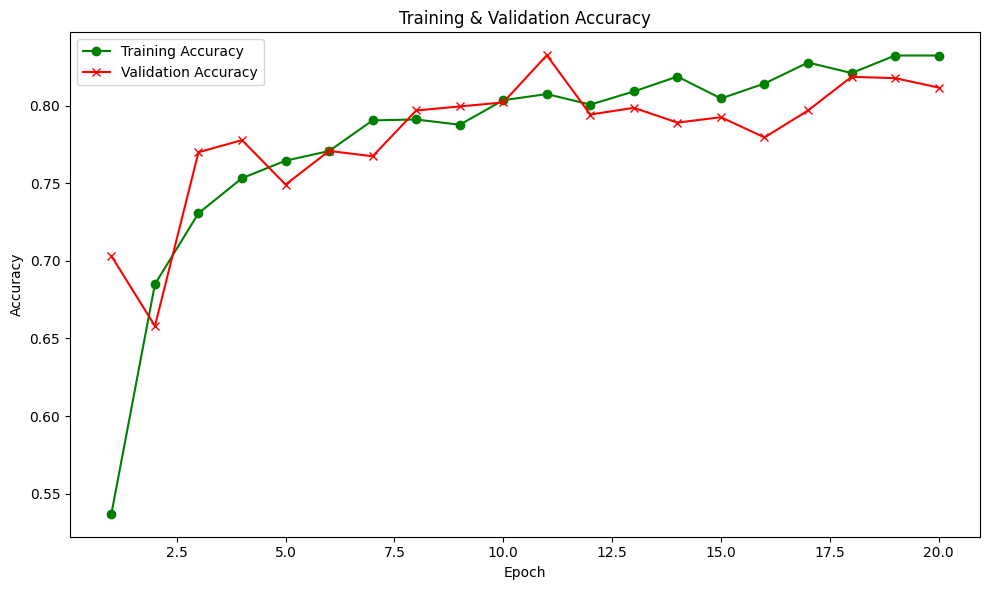

In [62]:
# Load the best model info
best_model_info = torch.load('RESNET50_best_model.pth')

# Extract the metrics from the loaded model info
training_losses = best_model_info['training_losses']
training_accuracies = best_model_info['training_accuracies']
validation_losses = best_model_info['validation_losses']
validation_accuracies = best_model_info['validation_accuracies']
num_epochs = len(training_losses)

# Define the epochs array
epochs = np.arange(1, num_epochs + 1)

# Define the colors for the plot
color_loss = 'blue'
color_val_loss = 'orange'
color_acc = 'green'
color_val_acc = 'red'

# Plot for Loss
plt.figure(figsize=(10, 6))
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, training_losses, label='Training Loss', marker='o', color=color_loss)
plt.plot(epochs, validation_losses, label='Validation Loss', marker='x', color=color_val_loss)
plt.legend()
plt.tight_layout()
plt.show()

# Plot for Accuracy
plt.figure(figsize=(10, 6))
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epochs, training_accuracies, label='Training Accuracy', marker='o', color=color_acc)
plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='x', color=color_val_acc)
plt.legend()
plt.tight_layout()
plt.show()